## Pokemon Tier Modelling

Tiers are a way to classify pokemon based on how useful they are in battle. When competing in a particular tier, you can use any pokemon from that tier or below. Pokemon can change tiers based on their usage. For example, if too many players use a particular pokemon in a tier, that pokemon can be promoted to a higher tier. This is done to maintain balance and variety within each tier.

Typically, tier evaluations for pokemon are ongoing. However, there is always a big re-evaluation each generation, as new pokemon, items, and mechanics are introduced. Here, we will model pokemon changing tiers as a discrete time markov chain. Since the future tier of a pokemon only depends on its current tier (since that is where it is evaluated), the markov property holds. Although there are many external factors influencing a pokemon's tier, we analyze the transitions irrespective of these factors.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Data Importing and Cleaning

We have extracted CSVs of pokemon data for each of the 7 generations. 

In [2]:
csv_df = [pd.read_csv(f'tier data/gen{i}.csv', delimiter=';') for i in range(1, 8)]

In [3]:
csv_df[0].sample()

,Name,Types,Abilities,Tier,HP,Attack,Defense,Special Attack,Special Defense,Speed,Next Evolution(s)
75,Magnemite,['Electric'],[],LC,25,35,70,95,95,45,['Magneton']


As of generation 7, there is a new Untiered tier, which consists of pokemon which should be in PU (the lowest tier) but see extremely low usage. For this analysis we will put them in PU.

In [4]:
csv_df[6].loc[csv_df[6].Tier == 'Untiered', 'Tier'] = 'PU'

We will consider only the primary playable tiers. This means all pokemon in "borderline" tiers will be promoted to the tier above, and we will not consider tiers like LC (little cup) or AG (anything goes).

In [5]:
for i, df in enumerate(csv_df):
    df.loc[df.Tier == 'OUBL','Tier'] = 'Uber'
    df.loc[df.Tier == 'UUBL','Tier'] = 'OU'
    df.loc[df.Tier == 'RUBL','Tier'] = 'UU'
    df.loc[df.Tier == 'NUBL','Tier'] = 'RU'
    df.loc[df.Tier == 'PUBL','Tier'] = 'NU'
    csv_df[i] = df[df['Tier'].isin(['Uber', 'OU', 'UU', 'NU', 'RU', 'PU'])]
    print(csv_df[i].shape[0])

84
147
259
309
402
487
553


In [6]:
df = csv_df[-1][['Name']].set_index('Name')
csv_df = [df.set_index('Name') for df in csv_df]
for gen in range(1, 8):
    df[f'gen{gen}'] = df.index.map(lambda x: csv_df[gen-1].loc[x, 'Tier'] 
                        if x in csv_df[gen-1].index else None)

 Our analysis will be heavily affected by the missing tiers in the older generations. To alleviate this, let's exclude generation 1 from our analysis, and combine RU, NU and PU into NU. 

In [7]:
del df['gen1']

In [8]:
low_tiers = {'NU', 'PU', 'RU'}
df = df.applymap(lambda x: 'NU' if x in low_tiers else x)

In [9]:
tiers = ['Uber', 'OU', 'UU', 'NU'] #'RU', 'PU'
tier_mapping = {tier:num for num, tier in enumerate(tiers)}
def tier_num(tier):
    return tier_mapping[tier]

## Analysis

Let's look at the distribution of tiers.

In [10]:
tier_counts = df.apply(pd.Series.value_counts).fillna(0).astype(np.int32)
tier_counts = tier_counts / tier_counts.sum()
tier_counts

,gen2,gen3,gen4,gen5,gen6,gen7
NU,0.353383,0.298578,0.531250,0.622691,0.575949,0.649186
OU,0.360902,0.350711,0.208333,0.153034,0.156118,0.137432
UU,0.248120,0.284360,0.180556,0.155673,0.183544,0.126582
Uber,0.037594,0.066351,0.079861,0.068602,0.084388,0.086799


Text(0.5,1,'Distribution of Pokemon Among Tiers by Generation')

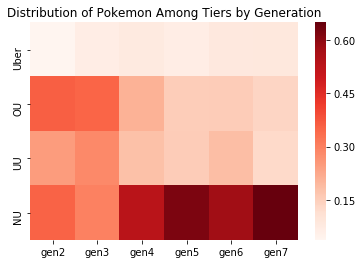

In [11]:
sns.heatmap(tier_counts.loc[tiers], cmap="Reds").set_title('Distribution of Pokemon Among Tiers by Generation')

In generations 2 and 3 (which only have the 4 tiers listed), there is an even distribution of pokemon in the 3 lower tiers. The higher generations have most of the pokemon in the lower tiers for two reasons. First, we combined the lower tiers in the higher generation. Second, by design, the lowest tier has the most pokemon for newer generations.

Let's create an Alluvial diagram visualizing how pokemon switch between various tiers.

In [12]:
p = df.copy()
p['cat'] = p['gen7']
p = p.set_index('cat')
?p.set_index

In [13]:
p = df.copy()
p['cat'] = p['gen7']
p = p.set_index('cat', append=True).stack().reset_index()
p.columns = ['Name', 'Tier in Gen 7', 'Gen', 'Tier']
p.Gen = p.Gen.map(lambda x: x[-1]).astype(int)
p.Tier = p.Tier.map(lambda x: 3-tier_mapping[x])

Text(0.5,1,'Pokemon Tier by Generation')

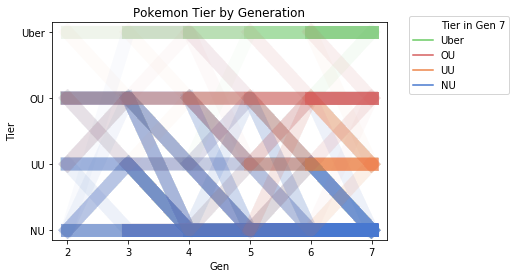

In [14]:
from matplotlib.ticker import MaxNLocator

ax = sns.lineplot(data=p, x='Gen', y='Tier', units='Name',
             estimator=None, alpha = 0.03, lw=13, hue='Tier in Gen 7',
                 palette='muted')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_yticklabels([None]+tiers[::-1])
handles, labels = ax.get_legend_handles_labels()
order = [0,3,4,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.05, 1.05))
ax.set_title("Pokemon Tier by Generation")

In this visualization, there is one line per pokemon. These lines overlap, so a darker line indicates more pokemon. We can see that it is far more common for pokemon to go to a lower tier than it is for them to go to a higher tier. It is uncommon for a pokemon to jump more than one tier at a time, and rare for a pokemon to jump more than 2 at a time. There seems to be one interesting case where a pokemon went from NU to Uber in one tier:

In [15]:
df[(df['gen2'] == 'NU') & (df['gen3'] == 'Uber')]

,gen2,gen3,gen4,gen5,gen6,gen7
Name,,,,,,
Wobbuffet,NU,Uber,Uber,OU,NU,NU


This happened because there were no abilities in Gen 2, then Wobbuffet gained the ability Shadow Tag in Gen 3, which made it quite overpowered. 

## Discrete Time Markov Chain

Given this analysis, let's construct the one step transition matrix for the discrete time markov chain. For simplicity, we will assume the markov chain is time homogenous:

In [16]:
dfs = [df[df.columns[i:i+2]] for i in range(2, 5)]
for d in dfs:
    d.columns = ["start", "end"]

transitions = pd.concat(dfs).dropna()
transitions['ind'] = 1

In [17]:
trans_matrix = transitions.groupby(['start', 'end']).agg('sum').reset_index()
trans_matrix = trans_matrix.pivot(index='start', columns='end', values='ind').fillna(0)
trans_matrix = trans_matrix.loc[tiers, tiers]

temp = pd.concat([trans_matrix.sum(axis=1)]*4, axis=1)
temp.columns = tiers

trans_matrix = trans_matrix/temp

trans_matrix

end,Uber,OU,UU,NU
start,,,,
Uber,0.865169,0.112360,0.022472,0.000000
OU,0.010417,0.567708,0.317708,0.104167
UU,0.005051,0.106061,0.449495,0.439394
NU,0.000000,0.015106,0.031722,0.953172


We can see that a large proportion pokemon from Ubers and NU stay in those tiers. Also, while all other pairs of states communicate directly, no pokemon have gone directy from Ubers to NU or vice versa. Interestingly, given a pokemon is in UU, there is less than a 50% chance of it staying in UU in the next generation. This suggests that the middle tiers change a lot, whereas the outer tiers are more stable. Let's visualize this chain as a graph:

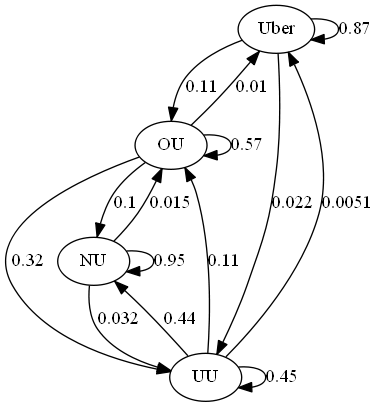

In [18]:
from graphviz import Digraph
import graphviz
import pydotplus
from IPython.display import Image  

dot = Digraph()
for n in tiers:
    dot.node(n, n)
    
for start in tiers:
    for end in tiers:
        if trans_matrix.loc[start, end] > 0.000001:
            dot.edge(start, end, f"{trans_matrix.loc[start, end]:.2}")

graph = pydotplus.graph_from_dot_data(dot.source)  
Image(graph.create_png())

This markov chain is clearly irreducible, aperiodic, and positive recurrent, thus we can find a unique stationary distribution. We can then compare this stationary distribution to the initial distribution and the current distribution of tiers in Pokemon.

In [19]:
matrix = trans_matrix.values
stationary_distro = np.linalg.eig(matrix.T)[1][:, 0]
stationary_distro = stationary_distro/np.sum(stationary_distro)
stationary_distro

array([0.00696016, 0.0514703 , 0.07965529, 0.86191425])

In [20]:
stationary_distro @ matrix @ matrix @ matrix #double check that this is the stationary distribution

array([0.00696016, 0.0514703 , 0.07965529, 0.86191425])

This result makes sense: pokemon in the uber tier tend to stay in that tier, whereas lower tier pokemon have a higher chance of being promoted. So, a stationary distribution would have a small density for Ubers and a larger one for NU.

Let's compare this stationary distribution to the distribution in the tiers

In [21]:
tier_distro = tier_counts
tier_distro['Stationary'] = stationary_distro[::-1]
tier_distro.columns = [f'Gen {i}' for i in range(2, 8)] + ['Stationary']
tier_distro = tier_distro.stack().reset_index()
tier_distro.columns = ['Tier', 'Category', 'Proportion']

Text(0.5,1,'Stationary Distribution vs Actual Distribution')

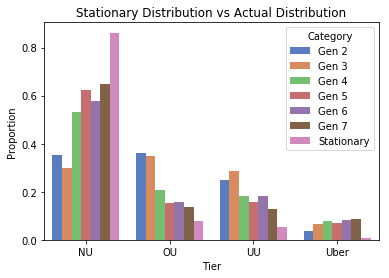

In [22]:
ax = sns.barplot(data=tier_distro, x='Tier', 
            hue='Category', y='Proportion',
            palette='muted')
ax.set_title("Stationary Distribution vs Actual Distribution")

As we saw in the heatmap, the older generations have a more even tier distribution than the new generations. However, gen 7's distribution is closer to that of the actual stationary distribution. In reality, the distribution of the tiers is kept stable by external factors, and the tiers shouldn't be extremely different (for playability). Furthermore, this distribution is another side effect of grouping the lower tiers together, particularly for the newer generations

## Conclusion 

In this notebook, we explored how a pokemon's competitive tier may change over the course of several generations. We saw that in general, pokemon are demoted rather than promoted. The markov chain showed us that all the states communicate, though Uber and NU don't have a direct connection. Also, we say that the extreme states are more stable than the middle ones. Finally, since we had an irreducible, aperiodic, and positive recurrent, we found the limiting distribution and compared it to the actual distribution of the pokemon in the generations.